In [1]:
%load_ext autoreload
%autoreload 2

# Install & import libraries 📚

In [2]:
import sklearn
from tsai.basics import *
my_setup(sklearn)

os              : Linux-5.19.0-38-generic-x86_64-with-glibc2.35
python          : 3.10.4
tsai            : 0.3.5
fastai          : 2.7.11
fastcore        : 1.5.28
sklearn         : 1.2.1
torch           : 1.13.1+cu117
device          : 1 gpu (['NVIDIA GeForce RTX 3080 Ti'])
cpu cores       : 12
threads per cpu : 2
RAM             : 31.27 GB
GPU memory      : [12.0] GB


# Load and prepare data 🔢

## Data preparation steps

There are 5 steps required to prepare data for a forecasting task in `tsai`:

1. Prepare a dataframe with your data, including the variable you want to predict. 
2. Preprocess your data.
3. Define train, valid and test splits.
4. Scale your data using the train split. 
5. Apply a sliding window to prepare your input and output data.

### Prepare dataframe

In [3]:
df_raw = pd.read_csv("../files/1000/full.csv")
df_raw

,start_time,end_time,size,networkin,networkout,disk_read,disk_write,memory,s_time,sends,cpu_allocations,rss_memory,data_memory,u_time,kcache
0,1684467528251812880,1684467528252812880,136260.0,1.377740e+05,462.0,88174592,12288,7356370944,321,64,320165,1109479424,2533560320,1528,0.0
1,1684467528252812880,1684467528253812880,136260.0,2.740340e+05,924.0,88174592,12288,7356370944,321,64,320165,1109479424,2533560320,1528,0.0
2,1684467528253812880,1684467528254812880,136260.0,4.102940e+05,1320.0,88174592,12288,7356370944,321,64,320165,1109479424,2533560320,1528,0.0
3,1684467528254812880,1684467528255812880,110522.0,5.465540e+05,1650.0,88174592,12288,7356370944,321,64,320165,1109479424,2533560320,1528,0.0
4,1684467528255812880,1684467528256812880,93868.0,6.570760e+05,1980.0,88174592,12288,7356370944,321,64,320165,1109479424,2533560320,1528,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3417894,1684470946147812880,1684470946148812880,0.0,2.486355e+11,755066142.0,88174592,12288,7658979328,75131,118,2251570247138,1540198400,2970423296,134082,0.0
3417895,1684470946148812880,1684470946149812880,315.0,2.486355e+11,755066412.0,88174592,12288,7658979328,75131,118,2251570251438,1540198400,2970423296,134082,0.0
3417896,1684470946149812880,1684470946150812880,184.0,2.486355e+11,755066701.0,88174592,12288,7658979328,75131,65,2251570353627,1540198400,2970423296,134082,0.0
3417897,1684470946150812880,1684470946151812880,184.0,2.486355e+11,755066989.0,88174592,12288,7658979328,75131,118,2251570394309,1540198400,2970423296,134082,0.0


### Proprocess dataframe

`tsai` provides some sklearn-style transforms that can be used to build a preprocessing pipeline. In this case we'll use the following transforms: 

* TSShrinkDataFrame: to save some memory and set the right dtypes.
* TSDropDuplicates: to ensure there are no duplicate timestamps.
* TSAddMissingTimestamps: to fill any missing timestamps. 
* TSFillMissing: to fill any missing data (forward fill, then 0).

All these transforms can be applied to the entire dataset. In other words, they are not dependent on the training set. Other transforms will be applied later, when the training split is available.

You can read about all available transforms in the [docs](https://timeseriesai.github.io/tsai/data.preprocessing.html#sklearn-api-transforms).

In [4]:
datetime_col = "start_time"
columns = df_raw.columns

# pipeline
preproc_pipe = sklearn.pipeline.Pipeline([
    ('shrinker', TSShrinkDataFrame()), # shrink dataframe memory usage
    ], 
    verbose=True)
mkdir('data', exist_ok=True, parents=True)
save_object(preproc_pipe, 'data/preproc_pipe.pkl')
preproc_pipe = load_object('data/preproc_pipe.pkl')

df = preproc_pipe.fit_transform(df_raw)
df

data directory already exists.
Pipeline saved as data/preproc_pipe.pkl
Initial memory usage: 391.15 MB 
Final memory usage  : 254.25 MB  (-35.0%)
[Pipeline] .......... (step 1 of 1) Processing shrinker, total=   0.1s


,start_time,end_time,size,networkin,networkout,disk_read,disk_write,memory,s_time,sends,cpu_allocations,rss_memory,data_memory,u_time,kcache
0,1684467528251812880,1684467528252812880,136260.0,1.377740e+05,462.0,88174592,12288,7356370944,321,64,320165,1109479424,2533560320,1528,0.0
1,1684467528252812880,1684467528253812880,136260.0,2.740340e+05,924.0,88174592,12288,7356370944,321,64,320165,1109479424,2533560320,1528,0.0
2,1684467528253812880,1684467528254812880,136260.0,4.102940e+05,1320.0,88174592,12288,7356370944,321,64,320165,1109479424,2533560320,1528,0.0
3,1684467528254812880,1684467528255812880,110522.0,5.465540e+05,1650.0,88174592,12288,7356370944,321,64,320165,1109479424,2533560320,1528,0.0
4,1684467528255812880,1684467528256812880,93868.0,6.570760e+05,1980.0,88174592,12288,7356370944,321,64,320165,1109479424,2533560320,1528,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3417894,1684470946147812880,1684470946148812880,0.0,2.486355e+11,755066112.0,88174592,12288,7658979328,75131,118,2251570247138,1540198400,2970423296,134082,0.0
3417895,1684470946148812880,1684470946149812880,315.0,2.486355e+11,755066432.0,88174592,12288,7658979328,75131,118,2251570251438,1540198400,2970423296,134082,0.0
3417896,1684470946149812880,1684470946150812880,184.0,2.486355e+11,755066688.0,88174592,12288,7658979328,75131,65,2251570353627,1540198400,2970423296,134082,0.0
3417897,1684470946150812880,1684470946151812880,184.0,2.486355e+11,755067008.0,88174592,12288,7658979328,75131,118,2251570394309,1540198400,2970423296,134082,0.0


### Define splits

So we have transformed a multivariate time series with 966 time steps and 7 features (excluding the datetime) into:

* 803 input samples, with 7 features and 104 historical time steps
* 803 input samples, with 7 features and 60 future time steps.

It's very easy to create time forecasting splits in `tsai`. You can use as function called `get_forecasting_splits`:

In [5]:
fcst_history = 128 # # steps in the past
fcst_horizon = 64  # # steps in the future
valid_size   = 0.1  # int or float indicating the size of the training set
test_size    = 0.4  # int or float indicating the size of the test set

splits = get_forecasting_splits(df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, datetime_col=datetime_col,
                                valid_size=valid_size, test_size=test_size)
splits

(array([      0,       1,       2, ..., 1708788, 1708789, 1708790],
       dtype=int32),
 array([1708854, 1708855, 1708856, ..., 2050609, 2050610, 2050611],
       dtype=int32),
 array([2050675, 2050676, 2050677, ..., 3417705, 3417706, 3417707],
       dtype=int32))

### Scale dataframe

Now that we have defined the splits for this particular experiment, we'll scale the data: 

In [6]:
columns = df.columns
train_split = splits[0]

# pipeline
exp_pipe = sklearn.pipeline.Pipeline([
    ('scaler', TSStandardScaler(columns=columns)), # standardize data using train_split
    ], 
    verbose=True)
save_object(exp_pipe, 'data/exp_pipe.pkl')
exp_pipe = load_object('data/exp_pipe.pkl')

df_scaled = exp_pipe.fit_transform(df, scaler__idxs=train_split)
df_scaled

data directory already exists.
Pipeline saved as data/exp_pipe.pkl
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.5s


,start_time,end_time,size,networkin,networkout,disk_read,disk_write,memory,s_time,sends,cpu_allocations,rss_memory,data_memory,u_time,kcache
0,-1.732049,-1.732049,0.001549,-1.733121,-1.732323,0.0,0.0,-2.808102,-1.735534,-1.264327,-1.729933,-2.748720,-3.344809,-1.726275,0.0
1,-1.732047,-1.732047,0.001549,-1.733118,-1.732318,0.0,0.0,-2.808102,-1.735534,-1.264327,-1.729933,-2.748720,-3.344809,-1.726275,0.0
2,-1.732045,-1.732045,0.001549,-1.733114,-1.732315,0.0,0.0,-2.808102,-1.735534,-1.264327,-1.729933,-2.748720,-3.344809,-1.726275,0.0
3,-1.732043,-1.732043,0.001231,-1.733110,-1.732312,0.0,0.0,-2.808102,-1.735534,-1.264327,-1.729933,-2.748720,-3.344809,-1.726275,0.0
4,-1.732041,-1.732041,0.001025,-1.733107,-1.732309,0.0,0.0,-2.808102,-1.735534,-1.264327,-1.729933,-2.748720,-3.344809,-1.726275,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3417894,5.196786,5.196786,-0.000136,5.186833,5.186252,0.0,0.0,2.735444,5.182481,-1.264287,5.189990,2.952381,2.798352,5.191594,0.0
3417895,5.196788,5.196788,-0.000132,5.186833,5.186255,0.0,0.0,2.735444,5.182481,-1.264287,5.189990,2.952381,2.798352,5.191594,0.0
3417896,5.196790,5.196790,-0.000134,5.186833,5.186258,0.0,0.0,2.735444,5.182481,-1.264326,5.189990,2.952381,2.798352,5.191594,0.0
3417897,5.196792,5.196792,-0.000134,5.186833,5.186261,0.0,0.0,2.735444,5.182481,-1.264287,5.189990,2.952381,2.798352,5.191594,0.0


### Apply a sliding window

We'll approach the time series forecasting task as a supervised learning problem. Remember that `tsai` requires that both inputs and outputs have the following shape: 

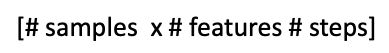

To get those inputs and outputs we're going to use a function called `prepare_forecasting_data` that applies a sliding window along the dataframe:

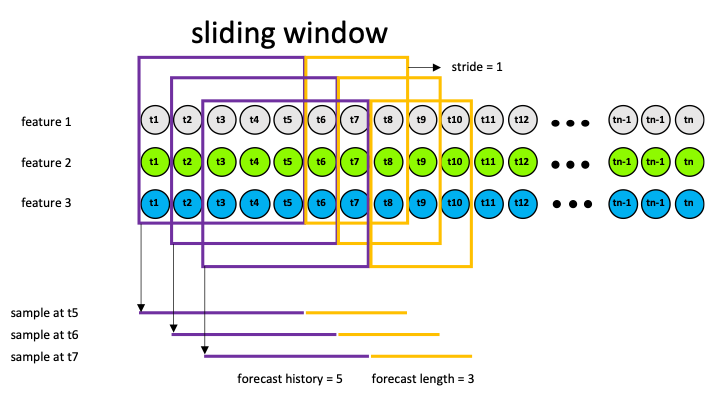

To use `prepare_forecasting_data` we need to define some settings: 

In [15]:
x_vars = df.columns[:-1]
y_vars = ['size']

In [16]:
df[y_vars]

,size
0,0.001549
1,0.001549
2,0.001549
3,0.001231
4,0.001025
...,...
3417894,-0.000136
3417895,-0.000132
3417896,-0.000134
3417897,-0.000134


In [17]:
X, y = prepare_forecasting_data(df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, x_vars=x_vars, y_vars=y_vars)
X.shape, y.shape

((3417708, 14, 128), (3417708, 1, 64))

# Prepare the forecaster 🏋️‍♂️

In [18]:
arch_config = dict(
)

In [19]:
learn = TSForecaster(X, y, splits=splits, batch_size=16, path="models", pipelines=[preproc_pipe, exp_pipe],
                     arch="PatchTST", arch_config=arch_config, metrics=[mse, mae], cbs=ShowGraph())

☢️ This is **not good practice**, but all papers using these long-term forecasting datasets have published there data using drop_last=True in the validtion set. You should never use it in your practice. But if you want to try and replicate the results from the paper, you may want to uncomment the following line and set `learn.dls.valid.drop_last=True`. 

In [20]:
# learn.dls.valid.drop_last = True

In [21]:
learn.summary()

not enough values to plot a chart


PatchTST (Input shape: 16 x 14 x 128)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 14 x 64        
RevIN                                     28         True      
____________________________________________________________________________
                     16 x 14 x 136       
ReplicationPad1d                                               
____________________________________________________________________________
                     16 x 16 x 16        
Unfold                                                         
____________________________________________________________________________
                     16 x 14 x 16 x 512  
Linear                                    8704       True      
Dropout                                                        
Linear                                    262656     True      
Linear                                    262656     True      
Linear                                    262656   

As you can see this is a very small model, with only 57k parameters!

# Train model 🏃🏿‍♂️

In this case we'll use the same number of epochs and learning rate they used in the paper. 

⚠️ Whenever you need to look for a good learning rate to train a model you can use:
```python
lr_max = learn.lr_find().valley
```

In [22]:
learn = TSForecaster(X, y, splits=splits, batch_size=16, path="models", pipelines=[preproc_pipe, exp_pipe],
                     arch="PatchTST", arch_config=arch_config, metrics=[mse, mae], cbs=[ShowGraph()])

n_epochs = 5
lr_max = learn.lr_find().valley
learn.fit_one_cycle(n_epochs, lr_max=lr_max)
learn.export('patchTST.pt')

RuntimeError: The size of tensor a (14336) must match the size of tensor b (1024) at non-singleton dimension 0

# Evaluate model 🕵️‍♀️

## Valid split

First we are going to check that the valid predictions match the results we got during training. But you can skip this step since it's not required.

In [ ]:
from tsai.inference import load_learner
from sklearn.metrics import mean_squared_error, mean_absolute_error

learn = load_learner('models/patchTST.pt')
scaled_preds, *_ = learn.get_X_preds(X[splits[1]])
scaled_preds = to_np(scaled_preds)
print(f"scaled_preds.shape: {scaled_preds.shape}")

scaled_y_true = y[splits[1]]
results_df = pd.DataFrame(columns=["mse", "mae"])
results_df.loc["valid", "mse"] = mean_squared_error(scaled_y_true.flatten(), scaled_preds.flatten())
results_df.loc["valid", "mae"] = mean_absolute_error(scaled_y_true.flatten(), scaled_preds.flatten())
results_df

## Test split

In [ ]:
from tsai.inference import load_learner
from sklearn.metrics import mean_squared_error, mean_absolute_error

learn = load_learner('models/patchTST.pt')
y_test_preds, *_ = learn.get_X_preds(X[splits[2]])
y_test_preds = to_np(y_test_preds)
print(f"y_test_preds.shape: {y_test_preds.shape}")

y_test = y[splits[2]]
results_df = pd.DataFrame(columns=["mse", "mae"])
results_df.loc["test", "mse"] = mean_squared_error(y_test.flatten(), y_test_preds.flatten())
results_df.loc["test", "mae"] = mean_absolute_error(y_test.flatten(), y_test_preds.flatten())
results_df

### Visualize predictions

In [ ]:
X_test = X[splits[2]]
y_test = y[splits[2]]
plot_forecast(X_test, y_test, y_test_preds, sel_vars=True)